# Workflow Model 1

## Import dataset

- For this model, we decide to import the dataset via KaggleHub.
- The model will be saved locally.
- We then print and save the path in a dotenv file for data protection.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

In [9]:
from dotenv import dotenv_values

# Retrieve dotenv config
config = dotenv_values(".env")

# Retrieve DATASET_URI
DATASET_URI=config["DATASET_URI"]

## Pre-processing

### Imports

In [11]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras

### Data conversion

In [12]:
# Define the parameters.

random.seed(10)
batch_size = 32 # TODO : add comment on what it does
img_height = 180 # TODO : add comment on what it does
img_width = 180 # TODO : add comment on what it does
seed = random.randint(1, 200)

# We then import the dataset from directory and store the data in train and test.
# We follow a rule of 80% for training and 20% for testing.

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Training classes => ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Testing classes => ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


### Data visualisation

#### Shape

The results below tell us that :

- The image_batch is a tensor of the shape (32, 180, 180, 3).
- This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
- The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [13]:
# Print the shapes of the training and the testing dataset
for image_batch, labels_batch in train_ds:
    print(f"Shape of the training set images => {image_batch.shape}")
    print(f"Shape of the training set labels => {labels_batch.shape}")
    break

for image_batch, labels_batch in test_ds:
    print(f"Shape of the testing set images => {image_batch.shape}")
    print(f"Shape of the testing set labels => {labels_batch.shape}")
    break

Shape of the training set images => (32, 180, 180, 3)
Shape of the training set labels => (32,)
Shape of the testing set images => (32, 180, 180, 3)
Shape of the testing set labels => (32,)


#### Pre-visualization

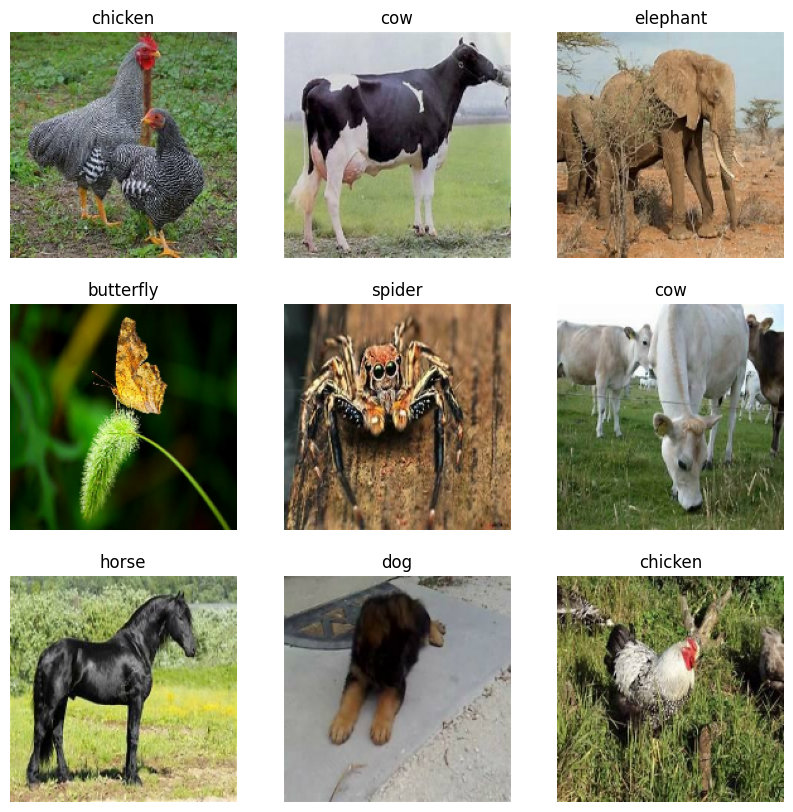

In [14]:
# Print a summary of the image classes with an image of each class.
# We will extract 1 image of the training set.

plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
  for i in range(len(class_names) - 1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model training

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

- Because we are working with images, the images are in the [0, 255] range.
- We therefore want to normalize the data to values from [0, 1].
- That way, the model will be more pertinent.


In [16]:
num_classes = len(class_names)

# Model creation
model_1 = keras.Sequential([
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

# Print the model summary
print(f"Model summary => {model_1.summary()}")

# Model compilation
model_1.compile(
  optimizer='adam',
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Model training
model_1_hist = model_1.fit(
  train_ds,
  validation_data=train_ds,
  epochs=5
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model summary => None
Epoch 1/5
 39/655 ━━━━━━━━━━━━━━━━━━━━ 1:22 134ms/step - accuracy: 0.1679 - loss: 2.2931

2025-04-17 16:16:03.348304: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 75/655 ━━━━━━━━━━━━━━━━━━━━ 1:15 130ms/step - accuracy: 0.1778 - loss: 2.2598

2025-04-17 16:16:07.894918: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


 82/655 ━━━━━━━━━━━━━━━━━━━━ 1:14 131ms/step - accuracy: 0.1802 - loss: 2.2543

2025-04-17 16:16:08.815571: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


104/655 ━━━━━━━━━━━━━━━━━━━━ 1:10 129ms/step - accuracy: 0.1898 - loss: 2.2338

2025-04-17 16:16:11.509539: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


119/655 ━━━━━━━━━━━━━━━━━━━━ 1:08 129ms/step - accuracy: 0.1966 - loss: 2.2191

2025-04-17 16:16:13.400885: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


125/655 ━━━━━━━━━━━━━━━━━━━━ 1:08 129ms/step - accuracy: 0.1992 - loss: 2.2134

2025-04-17 16:16:14.244601: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


173/655 ━━━━━━━━━━━━━━━━━━━━ 1:03 132ms/step - accuracy: 0.2179 - loss: 2.1719

2025-04-17 16:16:20.863927: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


240/655 ━━━━━━━━━━━━━━━━━━━━ 53s 130ms/step - accuracy: 0.2388 - loss: 2.1237

2025-04-17 16:16:29.278485: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


250/655 ━━━━━━━━━━━━━━━━━━━━ 52s 130ms/step - accuracy: 0.2414 - loss: 2.1174

2025-04-17 16:16:30.513471: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


379/655 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.2709 - loss: 2.0446

2025-04-17 16:16:46.659424: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


398/655 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - accuracy: 0.2747 - loss: 2.0350

2025-04-17 16:16:49.423043: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


453/655 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - accuracy: 0.2853 - loss: 2.0082

2025-04-17 16:16:56.519903: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


461/655 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.2868 - loss: 2.0044

2025-04-17 16:16:57.509427: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


483/655 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.2908 - loss: 1.9942

2025-04-17 16:17:00.299218: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


493/655 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.2926 - loss: 1.9897

2025-04-17 16:17:01.692924: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


583/655 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.3074 - loss: 1.9519

2025-04-17 16:17:13.267255: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


590/655 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.3085 - loss: 1.9491

2025-04-17 16:17:14.311590: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


623/655 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.3135 - loss: 1.9362

2025-04-17 16:17:18.949873: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


655/655 ━━━━━━━━━━━━━━━━━━━━ 111s 168ms/step - accuracy: 0.3183 - loss: 1.9240 - val_accuracy: 0.5533 - val_loss: 1.3142
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 100s 152ms/step - accuracy: 0.5603 - loss: 1.2954 - val_accuracy: 0.6792 - val_loss: 0.9585
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 101s 154ms/step - accuracy: 0.6590 - loss: 1.0071 - val_accuracy: 0.7186 - val_loss: 0.8339
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 107s 163ms/step - accuracy: 0.7362 - loss: 0.7742 - val_accuracy: 0.7975 - val_loss: 0.5947
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 112s 171ms/step - accuracy: 0.8044 - loss: 0.5867 - val_accuracy: 0.8398 - val_loss: 0.4735


## Model evaluation

### Retrieve the keys

In [18]:
print(model_1_hist.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


### Print the graph

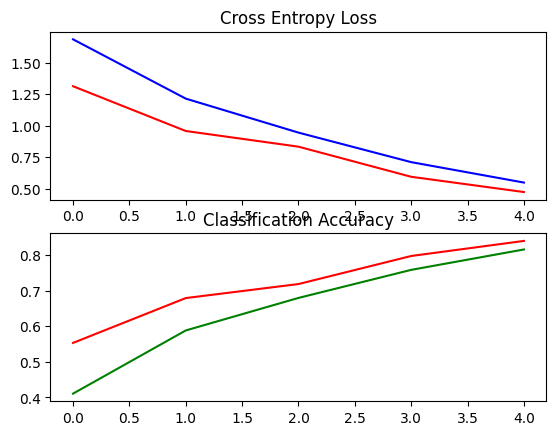

In [19]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(model_1_hist.history['loss'], color='blue', label='train')
plt.plot(model_1_hist.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(model_1_hist.history['accuracy'], color='green', label='train')
plt.plot(model_1_hist.history['val_accuracy'], color='red', label='val')
plt.show()

### Evaluate the model

In [23]:
test_loss, test_acc = model_1.evaluate(test_ds, verbose=1)
print('Test loss => ', test_loss)
print('Test accuracy => ', test_acc)

164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5975 - loss: 1.5478
Test loss =>  1.5441933870315552
Test accuracy =>  0.5996179580688477


### Test the predictions

In [24]:
import numpy as np
predictions = model_1.predict(test_ds)

print(predictions.shape)
predictions = np.argmax(predictions, axis=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
(5235, 10)


### Print confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix
gt = np.argmax(test_ds)

confusion_matrix(gt, predictions)

InvalidParameterError: The 'y_true' parameter of confusion_matrix must be an array-like. Got np.int64(0) instead.